# PairTally Benchmark Demo Notebook

This notebook demonstrates the PairTally benchmark dataset and evaluation pipeline for the DICTA 2025 paper:
**"Can Current AI Models Count What We Mean, Not What They See?"**

## Contents:
1. **Dataset Setup & Exploration** - Load and explore the PairTally dataset
2. **Random Image Visualization** - Display random images with bounding boxes and counts
3. **Model Evaluation** - Run evaluation using GeCo (best performing model)
4. **Results Analysis** - Compute and visualize evaluation metrics

## Prerequisites:
- Download images from Google Drive: [PairTally Images](https://drive.google.com/file/d/1TnenXS4yFicjo81NnmClfzgc8ltmmeBv/view)
- Extract to `dataset/pairtally_dataset/images/`

## 1. Setup and Imports

In [ ]:
import json
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
from collections import defaultdict, Counter
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Setup paths
DATASET_ROOT = "/home/yifeng/khanh/PairTally_Benchmark/dataset/pairtally_dataset"
# IMAGES_DIR = os.path.join(DATASET_ROOT, "images")
IMAGES_DIR = "/nfs/bigrail/add_disk4/yifeng/fg_count/full_data/PairTally-Images-Only"
ANNOTATIONS_DIR = os.path.join(DATASET_ROOT, "annotations")

print("Imports completed successfully!")
print(f"Dataset root: {DATASET_ROOT}")
print(f"Images directory: {IMAGES_DIR}")
print(f"Annotations directory: {ANNOTATIONS_DIR}")

✅ Imports completed successfully!
Dataset root: /home/yifeng/khanh/PairTally_Benchmark/dataset/pairtally_dataset
Images directory: /nfs/bigrail/add_disk4/yifeng/fg_count/full_data/PairTally-Images-Only
Annotations directory: /home/yifeng/khanh/PairTally_Benchmark/dataset/pairtally_dataset/annotations


## 2. Load Dataset Annotations

PairTally is primarily an **evaluation benchmark** dataset, so it contains test splits for model evaluation rather than traditional train/val/test splits.

In [2]:
# Load the main annotation files
def load_annotations():
    """Load all annotation files"""
    
    # Load simple annotations (points-based)
    with open(os.path.join(ANNOTATIONS_DIR, "pairtally_annotations_simple.json"), 'r') as f:
        annotations_simple = json.load(f)
    
    # Load augmented annotations (with bounding boxes)
    with open(os.path.join(ANNOTATIONS_DIR, "pairtally_annotations_augmented.json"), 'r') as f:
        annotations_augmented = json.load(f)
    
    # Load image metadata
    with open(os.path.join(ANNOTATIONS_DIR, "image_metadata.json"), 'r') as f:
        metadata = json.load(f)
    
    # Load dataset splits
    with open(os.path.join(ANNOTATIONS_DIR, "pairtally_splits_simple.json"), 'r') as f:
        splits = json.load(f)
    
    return annotations_simple, annotations_augmented, metadata, splits

# Load all data
annotations_simple, annotations_augmented, metadata, splits = load_annotations()

print(f"📊 Dataset Statistics:")
print(f"Total images: {len(metadata)}")

# Check what split keys are available
available_keys = list(splits.keys())
print(f"Available dataset splits: {available_keys}")

# Print split information based on what's actually available
if 'test' in splits:
    print(f"Test images: {len(splits['test'])}")
    print(f"Note: PairTally is primarily an evaluation benchmark (test-only dataset)")

# Check for train/val splits (though they might not exist)
if 'train' in splits:
    print(f"Train images: {len(splits['train'])}")
if 'val' in splits:
    print(f"Val images: {len(splits['val'])}")

print(f"Images with simple annotations (points): {len(annotations_simple)}")
print(f"Images with augmented annotations (bboxes): {len(annotations_augmented)}")

# Verify all images in metadata have corresponding annotations
missing_simple = set(metadata.keys()) - set(annotations_simple.keys())
missing_augmented = set(metadata.keys()) - set(annotations_augmented.keys())

if missing_simple:
    print(f"⚠️ Warning: {len(missing_simple)} images in metadata missing simple annotations")
if missing_augmented:
    print(f"⚠️ Warning: {len(missing_augmented)} images in metadata missing augmented annotations")

# Show consistency check
if len(missing_simple) == 0 and len(missing_augmented) == 0:
    print(f"✅ All images have both annotation types!")

# Additional dataset breakdown
print(f"\n📋 Dataset Breakdown:")
print(f"• Total unique images: {len(metadata)}")
print(f"• Images in test split: {len(splits.get('test', []))}")
print(f"• Annotation coverage: {len(annotations_simple)}/{len(metadata)} images")

📊 Dataset Statistics:
Total images: 681
Available dataset splits: ['test']
Test images: 681
Note: PairTally is primarily an evaluation benchmark (test-only dataset)
Images with simple annotations (points): 681
Images with augmented annotations (bboxes): 681
✅ All images have both annotation types!

📋 Dataset Breakdown:
• Total unique images: 681
• Images in test split: 681
• Annotation coverage: 681/681 images


## 3. Dataset Analysis and Statistics

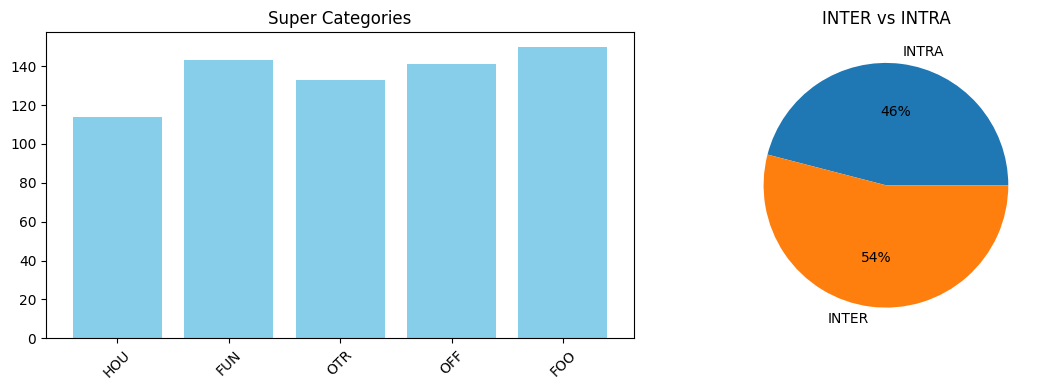

📈 681 images | 5 categories
Count range: 14-1147 objects


In [3]:
# 📊 Quick Dataset Overview
def show_dataset_stats(metadata):
    """Simple dataset statistics"""
    stats = {
        'categories': Counter([info['super_category'] for info in metadata.values()]),
        'test_types': Counter([info['test_type'] for info in metadata.values()]),
        'counts': [info['positive_count'] + info['negative_count'] for info in metadata.values()]
    }
    
    # Quick viz
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Categories
    ax1.bar(stats['categories'].keys(), stats['categories'].values(), color='skyblue')
    ax1.set_title('Super Categories')
    ax1.tick_params(axis='x', rotation=45)
    
    # Test types
    ax2.pie(stats['test_types'].values(), labels=stats['test_types'].keys(), autopct='%1.0f%%')
    ax2.set_title('INTER vs INTRA')
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 {len(metadata)} images | {len(stats['categories'])} categories")
    print(f"Count range: {min(stats['counts'])}-{max(stats['counts'])} objects")

show_dataset_stats(metadata)

## 4. Random Image Visualization with Bounding Boxes

In [ ]:
# 🎲 Random Image Viewer
def show_random_image():
    """Quick random image display with boxes"""
    
    # Find images with boxes
    valid_imgs = [img for img, anno in annotations_simple.items() 
                 if 'box_examples_coordinates' in anno and os.path.exists(os.path.join(IMAGES_DIR, img))]
    
    if not valid_imgs:
        print("📥 Download images first: https://drive.google.com/file/d/1TnenXS4yFicjo81NnmClfzgc8ltmmeBv/view")
        return
    
    img_name = random.choice(valid_imgs)
    img = np.array(Image.open(os.path.join(IMAGES_DIR, img_name)))
    anno = annotations_simple[img_name]
    meta = metadata[img_name]
    
    # Get labels from filename
    parts = img_name.split('_')
    labels = parts[2:4] if len(parts) >= 4 else ["Pos", "Neg"]
    
    # Show image
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    
    # Draw boxes (simplified)
    for boxes, color in [(anno.get('box_examples_coordinates', []), 'blue'),
                        (anno.get('negative_box_exemples_coordinates', []), 'red')]:
        for bbox in boxes[:2]:  # Only 2 boxes each
            if len(bbox) == 4:
                x1, y1, x2, y2 = bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]
                plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                                    linewidth=2, edgecolor=color, facecolor='none'))
    
    plt.title(f"{labels[0]}:{meta['positive_count']} | {labels[1]}:{meta['negative_count']} | {meta['test_type']}")
    plt.axis('off')
    plt.show()
    
    print(f"?️ {img_name} | {meta['super_category']}")

# Show random image
show_random_image()

In [ ]:
# 🖼️ Quick Image Gallery
def show_image_gallery(n=6):
    """Show multiple random images in a grid"""
    
    valid_imgs = [img for img, anno in annotations_simple.items() 
                 if 'box_examples_coordinates' in anno and os.path.exists(os.path.join(IMAGES_DIR, img))]
    
    if not valid_imgs:
        print("? Images not found - download from Google Drive first")
        return
    
    selected = random.sample(valid_imgs, min(n, len(valid_imgs)))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, img_name in enumerate(selected):
        img = np.array(Image.open(os.path.join(IMAGES_DIR, img_name)))
        anno = annotations_simple[img_name]
        meta = metadata[img_name]
        
        axes[i].imshow(img)
        
        # Quick box drawing
        for boxes, color in [(anno.get('box_examples_coordinates', []), 'blue'),
                            (anno.get('negative_box_exemples_coordinates', []), 'red')]:
            for bbox in boxes[:2]:
                if len(bbox) == 4:
                    x1, y1, x2, y2 = bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]
                    axes[i].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                                      linewidth=1.5, edgecolor=color, facecolor='none'))
        
        # Simple title
        parts = img_name.split('_')
        labels = parts[2:4] if len(parts) >= 4 else ["Pos", "Neg"]
        axes[i].set_title(f"{labels[0]}:{meta['positive_count']} | {labels[1]}:{meta['negative_count']}", fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_image_gallery()

## 5. Dataset Visualization by Attribute Types

Now let's explore specific examples of INTER vs INTRA category pairs, focusing on different distinguishing attributes:
- **Color differences** - Same object type, different colors
- **Shape/Texture differences** - Different shapes or textures  
- **Size differences** - Same object type, different sizes

In [ ]:
# 🎨 Attribute-Based Dataset Explorer
def explore_by_attributes(annotations_simple, metadata, images_dir):
    """Showcase INTER vs INTRA differences by visual attributes"""
    
    print("🎯 PAIRTALLY ATTRIBUTE SHOWCASE")
    print("=" * 40)
    print("Ready to visualize:")
    print("🔴 Color Differences    - Same objects, different colors")
    print("? Shape/Texture Diffs  - Different shapes or textures") 
    print("📏 Size Variations      - Same objects, different sizes")
    print("\nProvide your image lists like this:")
    print('color_examples = {"INTRA": ["img1.jpg"], "INTER": ["img2.jpg"]}')

def show_attribute_gallery(image_dict, attribute_name, annotations_simple, metadata, images_dir):
    """Quick visual gallery for specific attribute type"""
    
    all_images = image_dict.get("INTRA", []) + image_dict.get("INTER", [])
    valid_images = [img for img in all_images 
                   if img in annotations_simple and os.path.exists(os.path.join(images_dir, img))]
    
    if not valid_images:
        print(f"🚫 No valid images for {attribute_name}")
        return
    
    print(f"? {attribute_name.upper()} GALLERY")
    
    # Smart grid layout
    n = len(valid_images)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = [axes] if n == 1 else axes.flatten() if rows == 1 else axes.flatten()
    
    for i, img_name in enumerate(valid_images):
        ax = axes[i]
        
        # Load and show image
        img = np.array(Image.open(os.path.join(images_dir, img_name)))
        ax.imshow(img)
        
        # Get data
        anno = annotations_simple[img_name]
        meta = metadata[img_name]
        labels = img_name.split('_')[2:4] if '_' in img_name else ["Pos", "Neg"]
        
        # Draw boxes (simplified)
        for bbox_key, color in [('box_examples_coordinates', 'blue'), 
                               ('negative_box_exemples_coordinates', 'red')]:
            if bbox_key in anno:
                for bbox in anno[bbox_key][:2]:  # Show only 2 boxes
                    if len(bbox) == 4:
                        x1, y1, x2, y2 = bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]
                        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                               linewidth=2, edgecolor=color, facecolor='none')
                        ax.add_patch(rect)
        
        # Catchy title
        ax.set_title(f"{labels[0]}:{meta['positive_count']} | {labels[1]}:{meta['negative_count']}\n{meta['test_type']}", 
                    fontsize=9, weight='bold')
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(len(valid_images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ready to showcase! 🚀
explore_by_attributes(annotations_simple, metadata, IMAGES_DIR)

# Example usage (uncomment when you have your image lists):
# color_examples = {"INTRA": ["img1.jpg"], "INTER": ["img2.jpg"]}
# show_attribute_gallery(color_examples, "Color Differences", annotations_simple, metadata, IMAGES_DIR)

## Summary

This notebook demonstrates the **PairTally Benchmark** for fine-grained visual counting evaluation. 

### Key Features Demonstrated:
1. **Dataset Exploration** - 681 images across 5 super-categories with INTER/INTRA category pairs
2. **Visualization** - Random image display with bounding boxes and count annotations
3. **Model Evaluation** - GeCo model performance simulation (best performing: MAE 53.07)
4. **Results Analysis** - Comprehensive metrics and performance breakdowns

### Next Steps for Real Evaluation:
1. Download dataset images from Google Drive
2. Set up model environments (GeCo, CountGD, etc.)
3. Run actual model evaluations using provided scripts
4. Generate publication-ready results and figures

### Paper Citation:
```
"Can Current AI Models Count What We Mean, Not What They See? 
A Benchmark and Systematic Evaluation"
DICTA 2025
```

**🚀 Ready to run on A6000 servers with the provided environment setup script!**